/tmp/ipython-input-5504368.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ticket_revenue = tickets.groupby("ROUND_TRIP_ID").apply(
/tmp/ipython-input-5504368.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=busiest, x="route_str", y="round_trip_flights", palette="crest")


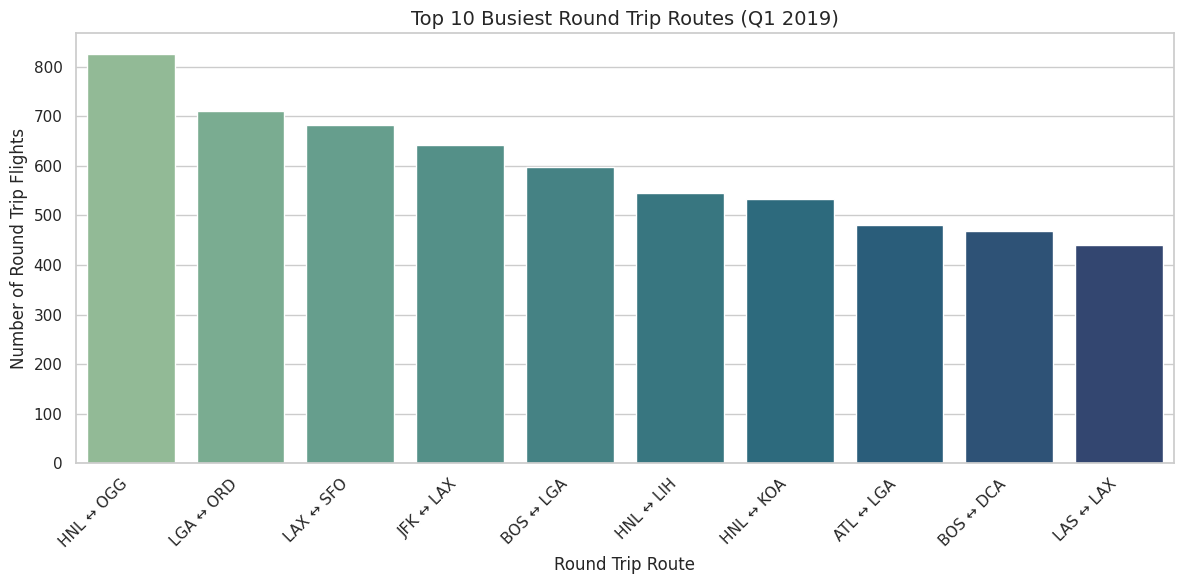

/tmp/ipython-input-5504368.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x=top5["ROUTE_ID"].astype(str), y="total_profit", palette="viridis")


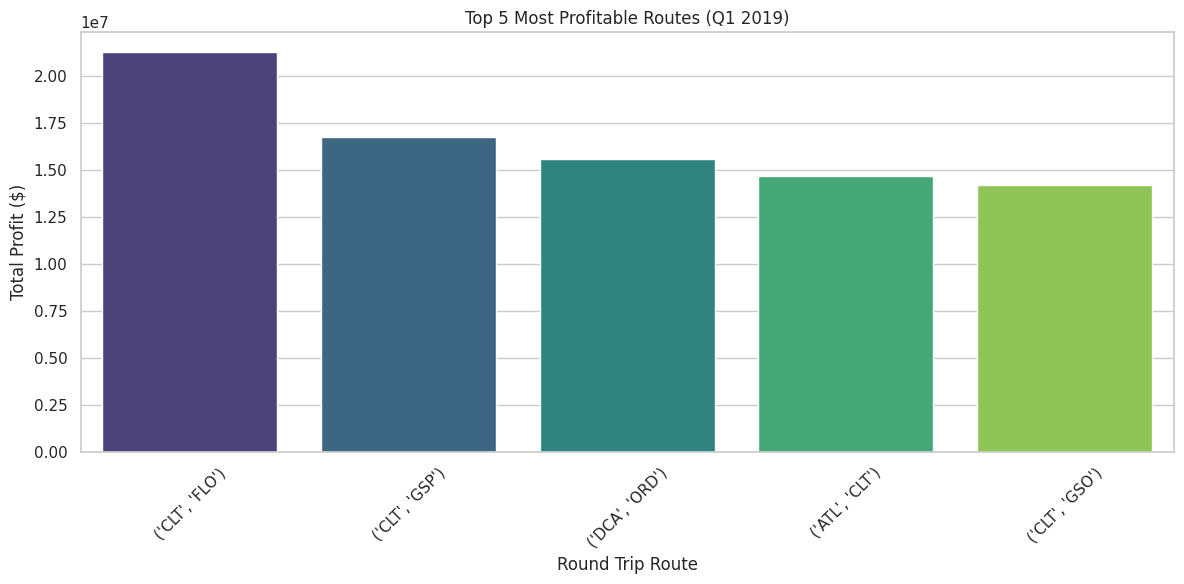

/tmp/ipython-input-5504368.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x=top5["ROUTE_ID"].astype(str), y="breakeven_flights", palette="coolwarm")


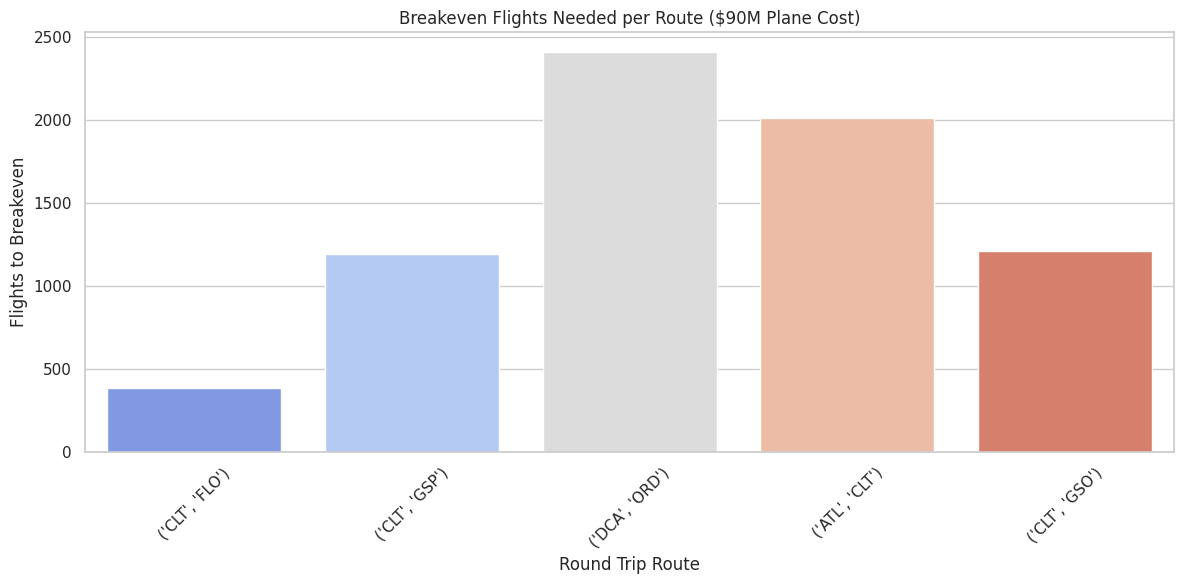

In [ ]:
# Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------
# 1. LOAD DATA
# -----------------------------------
flights = pd.read_csv("Flights.csv", low_memory=False)
tickets = pd.read_csv("Tickets.csv")
airports = pd.read_csv("Airport_Codes.csv")

# -----------------------------------
# 2. CLEAN & CONVERT DATA TYPES
# -----------------------------------
numeric_cols = ['DISTANCE', 'OCCUPANCY_RATE', 'DEP_DELAY', 'ARR_DELAY']
for col in numeric_cols:
    flights[col] = pd.to_numeric(flights[col], errors='coerce')

tickets["ITIN_FARE"] = pd.to_numeric(tickets["ITIN_FARE"], errors='coerce')
tickets["PASSENGERS"] = pd.to_numeric(tickets["PASSENGERS"], errors='coerce')

# Filter out canceled flights and invalid values
flights = flights[(flights['CANCELLED'] == 0) &
                  (flights['DISTANCE'] > 0) &
                  (flights['OCCUPANCY_RATE'] > 0)]

# -----------------------------------
# 3. FILTER FOR U.S. MEDIUM AND LARGE AIRPORTS
# -----------------------------------
us_airports = airports[(airports['ISO_COUNTRY'] == 'US') &
                       (airports['TYPE'].isin(['medium_airport', 'large_airport']))]

# Keep only IATA codes of relevant airports
valid_iata = us_airports['IATA_CODE'].dropna().unique()
flights = flights[flights['ORIGIN'].isin(valid_iata) & flights['DESTINATION'].isin(valid_iata)]
tickets = tickets[tickets['ORIGIN'].isin(valid_iata) & tickets['DESTINATION'].isin(valid_iata)]
tickets = tickets[tickets['ROUNDTRIP'] == 1]  # Round trip only

# -----------------------------------
# 4. CREATE ROUTE KEYS
# -----------------------------------
def route_id(origin, dest):
    return tuple(sorted([origin, dest]))

flights['ROUTE_ID'] = flights.apply(lambda row: route_id(row['ORIGIN'], row['DESTINATION']), axis=1)
tickets['ROUND_TRIP_ID'] = tickets.apply(lambda row: route_id(row['ORIGIN'], row['DESTINATION']), axis=1)

# -----------------------------------
# 5. CALCULATE TICKET REVENUE PER ROUTE
# -----------------------------------
ticket_revenue = tickets.groupby("ROUND_TRIP_ID").apply(
    lambda df: (
        (df["ITIN_FARE"] * df["PASSENGERS"]).sum() / df["PASSENGERS"].sum()
        if df["PASSENGERS"].sum() > 0 else 0
    )
).reset_index(name="avg_ticket_price")

# -----------------------------------
# 6. AGGREGATE FLIGHT DATA TO ROUND-TRIP ROUTES
# -----------------------------------
# Count round trip flights (i.e., pairs of out+return flights)
flight_counts = flights.groupby("ROUTE_ID").size().reset_index(name="flight_legs")
flight_counts["round_trip_flights"] = flight_counts["flight_legs"] // 2

# Calculate average occupancy, delays, etc.
agg_flight_data = flights.groupby("ROUTE_ID").agg({
    "DISTANCE": "mean",
    "OCCUPANCY_RATE": "mean",
    "DEP_DELAY": "mean",
    "ARR_DELAY": "mean"
}).reset_index()

# Merge with ticket price
financials = pd.merge(agg_flight_data, ticket_revenue, left_on="ROUTE_ID", right_on="ROUND_TRIP_ID", how="inner")

# Merge flight counts
financials = pd.merge(financials, flight_counts[["ROUTE_ID", "round_trip_flights"]], on="ROUTE_ID", how="left")

# -----------------------------------
# 7. CALCULATE COSTS & REVENUES
# -----------------------------------

# Constants
SEATS_PER_FLIGHT = 200
BAG_FEE_PER_RT_PASSENGER = 70  # $35 x 2
FUEL_CREW_COST_PER_MILE = 8
DEP_INS_OTHER_COST_PER_MILE = 1.18

def calculate_financials(row):
    rt_distance = row['DISTANCE'] * 2
    passengers = row['OCCUPANCY_RATE'] * SEATS_PER_FLIGHT
    base_revenue = passengers * row['avg_ticket_price']
    bag_revenue = passengers * 0.5 * 70
    total_revenue = base_revenue + bag_revenue

    distance_cost = rt_distance * (FUEL_CREW_COST_PER_MILE + DEP_INS_OTHER_COST_PER_MILE)

    # Airport costs
    airport_cost = 10000 * 2  # Assume both are large to be conservative

    # Delay costs
    dep_delay = max(row['DEP_DELAY'] - 15, 0)
    arr_delay = max(row['ARR_DELAY'] - 15, 0)
    delay_cost = (dep_delay + arr_delay) * 75

    total_cost = distance_cost + airport_cost + delay_cost

    profit = total_revenue - total_cost

    return pd.Series({
        "revenue": total_revenue,
        "cost": total_cost,
        "profit": profit
    })

financials = pd.concat([financials, financials.apply(calculate_financials, axis=1)], axis=1)

# Multiply by number of round trips
financials["total_profit"] = financials["profit"] * financials["round_trip_flights"]
financials["total_revenue"] = financials["revenue"] * financials["round_trip_flights"]
financials["total_cost"] = financials["cost"] * financials["round_trip_flights"]

# -----------------------------------
# 8. FIND TOP ROUTES
# -----------------------------------

# Top 10 busiest
busiest = financials.sort_values("round_trip_flights", ascending=False).head(10)

# Top 10 most profitable
most_profitable = financials.sort_values("total_profit", ascending=False).head(10)

# Recommend 5 routes
top5 = most_profitable.head(5).copy()
top5["breakeven_flights"] = 90_000_000 / top5["profit"]  # Airplane cost / per-flight profit

# -----------------------------------
# 9. VISUALIZE
# -----------------------------------
sns.set(style="whitegrid")
busiest["route_str"] = busiest["ROUTE_ID"].apply(lambda x: f"{x[0]} ↔ {x[1]}")
plt.figure(figsize=(12, 6))
sns.barplot(data=busiest, x="route_str", y="round_trip_flights", palette="crest")
plt.title("Top 10 Busiest Round Trip Routes (Q1 2019)", fontsize=14)
plt.ylabel("Number of Round Trip Flights", fontsize=12)
plt.xlabel("Round Trip Route", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=top5, x=top5["ROUTE_ID"].astype(str), y="total_profit", palette="viridis")
plt.title("Top 5 Most Profitable Routes (Q1 2019)")
plt.ylabel("Total Profit ($)")
plt.xlabel("Round Trip Route")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Breakeven visual
plt.figure(figsize=(12, 6))
sns.barplot(data=top5, x=top5["ROUTE_ID"].astype(str), y="breakeven_flights", palette="coolwarm")
plt.title("Breakeven Flights Needed per Route ($90M Plane Cost)")
plt.ylabel("Flights to Breakeven")
plt.xlabel("Round Trip Route")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
